In [110]:
import sys
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

### Load the measurements and production data.

In [111]:
# specify time range and number of production events
time_range_key = '1d'
prod_count = 1000 if time_range_key == '1y' else 100 if time_range_key == '1m' else 50 if time_range_key == '1w' else 10

In [112]:
# all data will be read from or stored under this folder
DATA_DIR = Path('data')

measurements_file = DATA_DIR / F"measurements-dummy-{time_range_key}.csv"
prod_file = DATA_DIR / F"production-dummy-{prod_count}-{time_range_key}.csv"

In [113]:
measure_df = pd.read_csv(measurements_file)
measure_df['timestamp'] = measure_df['timestamp'].apply(lambda x: pd.Timestamp(x))
measure_df.head()

,timestamp,m1,m2,m3,m4,m5
0,2018-01-01 00:00:00,66.780494,65.217221,48.842714,51.054600,56.330693
1,2018-01-01 00:00:30,57.675873,82.594139,67.128019,34.646194,49.404110
2,2018-01-01 00:01:00,65.254882,51.663527,49.967143,53.994720,27.718782
3,2018-01-01 00:01:30,48.868397,23.830365,63.191482,53.418901,61.711849
4,2018-01-01 00:02:00,55.270477,16.035617,46.767995,31.731472,60.183277


In [114]:
prod_df = pd.read_csv(prod_file)
prod_df['finished_time'] = prod_df['finished_time'].apply(lambda x: pd.Timestamp(x))
prod_df.head()

,duration,finished_time,efficiency
0,90,2018-01-01 03:00:04,51.108762
1,90,2018-01-01 04:30:06,27.203295
2,90,2018-01-01 06:00:08,98.806322
3,90,2018-01-01 09:00:12,50.763437
4,90,2018-01-01 10:30:14,53.172586


### Dev / debug

In [239]:
def merge_v4(prod_df, measure_df):
    '''
    1. run apply on prod_df
    2. loop over measure df
    3. keep track of index_start
    '''
    def merge(finished_time, duration, measure_df):
        global _iter_count
        global _index_start 
        t0 = pd.Timestamp.now()
        start_time = finished_time - pd.Timedelta(minutes=duration)
        measurements = []    
        for row in measure_df[_index_start:].itertuples():
            _iter_count += 1
            ts = row.timestamp
            if ts >= start_time and ts <= finished_time:
                measurements.append(ts)
            elif ts > finished_time:
                _index_start = row.Index
                break
        
        t0 = nano2milli((pd.Timestamp.now() - t0).value)
        return pd.Series({'measurements' : measurements, 'debug_time_ms' : t0})
    
    #prod_df[['measurements', 'debug_time_ms']] = prod_df.apply(lambda row: merge(row.finished_time, row.duration, measure_df), axis=1)
    prod_df[['measurements', 'debug_time_ms']] = prod_df.finished_time.apply(lambda finished_time: merge(finished_time, 90, measure_df))
    # no return needed as inout df is modified

measure_df2 = measure_df.copy()
prod_df2 = prod_df.copy()

# measure total time
t0 = pd.Timestamp.now()
# merge
_iter_count = 0
_index_start = 0
merge_v4(prod_df2, measure_df2)
# total time in seconds
t = (pd.Timestamp.now() - t0).value
print('iter_count:', _iter_count)
print('Time: {0:.4f}s'.format(nano2sec(t)))
print('debug_time_ms:\n', prod_df2[['debug_time_ms']].describe().T)
prod_df2

#merge_v5(prod_df2, measure_df2)

iter_count: 2712
Time: 0.1693s
debug_time_ms:
                count     mean        std  min       25%      50%      75%  \
debug_time_ms   10.0  16.9272  10.773101  0.0  15.62425  15.6255  22.1325   

                  max  
debug_time_ms  31.259  


,duration,finished_time,efficiency,measurements,debug_time_ms
0,90,2018-01-01 03:00:04,51.108762,"[2018-01-01 01:30:30, 2018-01-01 01:31:00, 201...",31.249
1,90,2018-01-01 04:30:06,27.203295,"[2018-01-01 03:00:30, 2018-01-01 03:01:00, 201...",15.626
2,90,2018-01-01 06:00:08,98.806322,"[2018-01-01 04:30:30, 2018-01-01 04:31:00, 201...",22.133
3,90,2018-01-01 09:00:12,50.763437,"[2018-01-01 07:30:30, 2018-01-01 07:31:00, 201...",31.259
4,90,2018-01-01 10:30:14,53.172586,"[2018-01-01 09:00:30, 2018-01-01 09:01:00, 201...",15.625
5,90,2018-01-01 13:30:18,35.733897,"[2018-01-01 12:00:30, 2018-01-01 12:01:00, 201...",15.625
6,90,2018-01-01 16:30:22,12.615963,"[2018-01-01 15:00:30, 2018-01-01 15:01:00, 201...",15.624
7,90,2018-01-01 18:00:24,29.400695,"[2018-01-01 16:30:30, 2018-01-01 16:31:00, 201...",0.000
8,90,2018-01-01 19:30:26,19.066323,"[2018-01-01 18:00:30, 2018-01-01 18:01:00, 201...",22.131
9,90,2018-01-01 22:30:30,85.564318,"[2018-01-01 21:00:30, 2018-01-01 21:01:00, 201...",0.000


In [178]:
prod_df.iloc[2]


duration                          90
finished_time    2018-01-01 06:00:08
efficiency                   98.8063
Name: 2, dtype: object

### Merge v1

In [247]:
nano2sec = lambda x: x / 10 ** 9 # convert nanoseconds to seconds
nano2milli = lambda x: x / 10 ** 6  # convert nanoseconds to milliseconds

def merge_v1(prod_df, measure_df):
    def merge(ts, prod_df):
        t0 = pd.Timestamp.now()
        prod_results = prod_df.loc[(ts <= prod_df.finished_time) & (ts >= prod_df.finished_time - pd.Timedelta(minutes=90))]
        finished_time = prod_results.iloc[0].finished_time if prod_results.size > 0 else None
        t0 = nano2milli((pd.Timestamp.now() - t0).value)
        return pd.Series({'finished_time': finished_time, 'debug_time_ms': t0})
    
    measure_df[['finished_time', 'debug_time_ms']] = measure_df['timestamp'].apply(lambda ts: merge(ts, prod_df))
    merged_df = measure_df[measure_df.finished_time.notnull()]
    return merged_df

def merge_v1_1(prod_df, measure_df):
    def merge(ts, prod_df):
        global iter_count
        global compare_time
        t0 = pd.Timestamp.now()
        finished_time = None
        # loop over prod_df
        for row in prod_df.itertuples():
            iter_count += 1
            t1 = pd.Timestamp.now()
            #cmp = ts >= row.finished_time - pd.Timedelta(minutes=row.duration) and ts <= row.finished_time
            cmp = ts <= row.finished_time and ts >= row.finished_time - pd.Timedelta(minutes=row.duration)
            t1 = (pd.Timestamp.now() - t1)
            compare_time += t1.value
            if cmp:
                # check if timestamp is in range [finished_time-duration, finished_tome]
                #if ts <= row.finished_time and ts >= row.finished_time - pd.Timedelta(minutes=row.duration):
                # Found! Return this finished_time
                finished_time = row.finished_time
                #break
        t0 = nano2milli((pd.Timestamp.now() - t0).value)
        return pd.Series({'finished_time': finished_time, 'debug_time_ms': t0})
    measure_df[['finished_time', 'debug_time_ms']] = measure_df['timestamp'].apply(lambda ts: merge(ts, prod_df))
    merged_df = measure_df[measure_df.finished_time.notnull()]
    return merged_df

def merge_v2(prod_df, measure_df):
    def merge(ts, prod_df):
        global iter_count
        global compare_time
        t0 = pd.Timestamp.now()
        finished_time = None
        # loop over prod_df
        for row in prod_df.itertuples():
            iter_count += 1
            # check if timestamp is in range [finished_time-duration, finished_tome]
            t1 = pd.Timestamp.now()
            #cmp = ts >= row.finished_time - pd.Timedelta(minutes=row.duration) and ts <= row.finished_time
            cmp = ts <= row.finished_time and ts >= row.finished_time - pd.Timedelta(minutes=row.duration)
            t1 = (pd.Timestamp.now() - t1)
            compare_time += t1.value
            if cmp:
            #if ts <= row.finished_time and ts >= row.finished_time - pd.Timedelta(minutes=row.duration):
                # Found! Return this finished_time
                finished_time = row.finished_time
                break
        t0 = nano2milli((pd.Timestamp.now() - t0).value)
        return pd.Series({'finished_time': finished_time, 'debug_time_ms': t0})
    measure_df[['finished_time', 'debug_time_ms']] = measure_df['timestamp'].apply(lambda ts: merge(ts, prod_df))
    merged_df = measure_df[measure_df.finished_time.notnull()]
    return merged_df

def merge_v3(prod_df, measure_df):
    _index_start = 0
    def merge(ts, prod_df):
        '''
        add to each measurement the production finished time
        if (measure.timestamp > finished_time - duration) and (measure.timestamp < finished_time)
        '''
        global _index_start
        global iter_count
        global compare_time
        finished_time = None
        t0 = pd.Timestamp.now()
        for row in prod_df[_index_start:].itertuples():
            # check if ts is in range
            iter_count += 1
            t1 = pd.Timestamp.now()
            #cmp = ts >= row.finished_time - pd.Timedelta(minutes=row.duration) and ts <= row.finished_time
            cmp = ts <= row.finished_time and ts >= row.finished_time - pd.Timedelta(minutes=row.duration)
            t1 = (pd.Timestamp.now() - t1)
            compare_time += t1.value
            #if ts >= row.finished_time - pd.Timedelta(minutes=row.duration) and ts <= row.finished_time:
            if cmp:
                # Found! Return this finished_time
                finished_time = row.finished_time
                # update the index start for the next search
                _index_start = row.Index
                break
        t0 = nano2milli((pd.Timestamp.now() - t0).value)
        return pd.Series({'finished_time': finished_time, 'debug_time_ms': t0})
    
    measure_df[['finished_time', 'debug_time_ms']] = measure_df['timestamp'].apply(lambda ts: merge(ts, prod_df))
    merged_df = measure_df[measure_df.finished_time.notnull()]
    return merged_df

def merge_v4(prod_df, measure_df):
    '''
    1. run apply on prod_df
    2. loop over measure df
    3. keep track of index_start
    '''
    def merge(finished_time, duration, measure_df):
        global _iter_count
        global _index_start 
        t0 = pd.Timestamp.now()
        start_time = finished_time - pd.Timedelta(minutes=duration)
        measurements = []    
        for row in measure_df[_index_start:].itertuples():
            _iter_count += 1
            ts = row.timestamp
            if ts >= start_time and ts <= finished_time:
                measurements.append(ts)
            elif ts > finished_time:
                _index_start = row.Index
                break
        
        t0 = nano2milli((pd.Timestamp.now() - t0).value)
        return pd.Series({'measurements' : measurements, 'debug_time_ms' : t0})
    
    #prod_df[['measurements', 'debug_time_ms']] = prod_df.apply(lambda row: merge(row.finished_time, row.duration, measure_df), axis=1)
    prod_df[['measurements', 'debug_time_ms']] = prod_df.finished_time.apply(lambda finished_time: merge(finished_time, 90, measure_df))
    return prod_df

def test_merge(prod_df, measure_df, merge_func):
    # clone measurements and prod data
    prod_df2 = prod_df.copy()
    measure_df2 = measure_df.copy()
    # measure total time
    t0 = pd.Timestamp.now()
    # merge
    merged_df = merge_func(prod_df2, measure_df2)
    # total time in seconds
    t = (pd.Timestamp.now() - t0).value
    # print stats
    print('>> Done!')
    print('  >> Total time: {0:.4f}s'.format(nano2sec(t)))
    print('  >> Time per measurement: {0:.4f}s'.format(nano2milli(t) / measure_df2.shape[0]))
    #desc = measure_df2.describe(percentiles=[.25, .5, .75, .9, .95, .99])
    desc = merged_df.describe(percentiles=[.25, .5, .75, .9, .95, .99])
    print('  >> Mean time: {0}'.format(desc['debug_time_ms'].loc['mean']))
    print('  >> Max time: {0}'.format(desc['debug_time_ms'].loc['max']))
    print('  >> Time at 25%: {0}'.format(desc['debug_time_ms'].loc['25%']))
    print('  >> Time at 50%: {0}'.format(desc['debug_time_ms'].loc['50%']))
    print('  >> Time at 75%: {0}'.format(desc['debug_time_ms'].loc['75%']))
    print('  >> Time at 90%: {0}'.format(desc['debug_time_ms'].loc['90%']))
    print('  >> Time at 95%: {0}'.format(desc['debug_time_ms'].loc['95%']))
    print('  >> Time at 95%: {0}'.format(desc['debug_time_ms'].loc['99%']))
    
    # plot
    sns.set(style="darkgrid")
    sns.set(rc={'figure.figsize':(40, 5)})
    plt.ylim(0, 6)
    sns.lineplot(x="finished_time", y="debug_time_ms", data=merged_df)
    
    # select mesurements with merged finished time
    merge_desc = merged_df.groupby('finished_time').size().describe()

    print('>> Merged stats:')
    print('  >> Number of production events: {0}'.format(merge_desc.loc['count']))
    print('  >> Number of measurements per event: {0}'.format(merge_desc.loc['mean']))
        
    return merged_df

#### Test merge_v1

>> Done!
  >> Total time: 10.7762s
  >> Time per measurement: 3.7417s
  >> Mean time: 3.2450777777777557
  >> Max time: 7.988
  >> Time at 25%: 2.997
  >> Time at 50%: 3.0
  >> Time at 75%: 3.0172499999999998
  >> Time at 90%: 3.999
  >> Time at 95%: 4.002
  >> Time at 95%: 4.01
>> Merged stats:
  >> Number of production events: 10.0
  >> Number of measurements per event: 180.1


,timestamp,m1,m2,m3,m4,m5,finished_time,debug_time_ms
181,2018-01-01 01:30:30,68.108305,74.521933,32.397499,54.095351,34.772458,2018-01-01 03:00:04,2.997
182,2018-01-01 01:31:00,41.789023,50.819777,25.278318,34.802171,43.864491,2018-01-01 03:00:04,3.999
183,2018-01-01 01:31:30,76.797885,56.761951,66.229944,55.841921,55.903782,2018-01-01 03:00:04,3.000
184,2018-01-01 01:32:00,49.333087,50.288513,63.647841,29.194204,25.185023,2018-01-01 03:00:04,3.002
185,2018-01-01 01:32:30,31.098806,51.672563,60.140801,54.277800,31.212572,2018-01-01 03:00:04,3.996


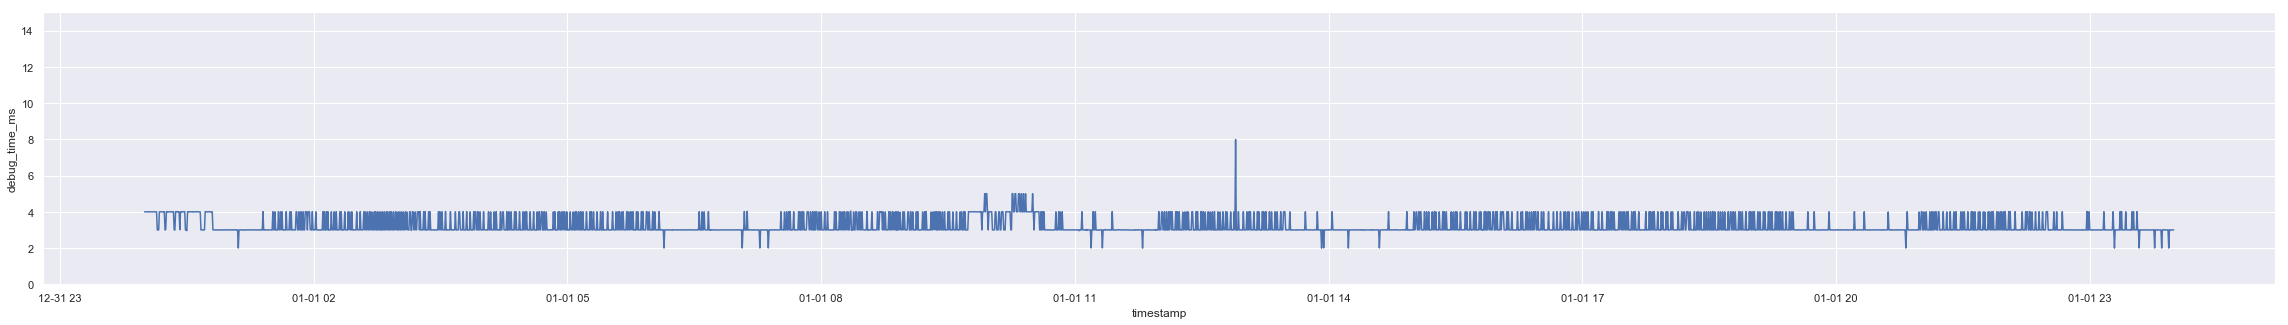

In [121]:
merged_v1_df = test_merge(prod_df, measure_df, merge_func=merge_v1)
merged_v1_df.head()

### Test merge_v1_1

>> Done!
  >> Total time: 7.0129s
  >> Time per measurement: 2.4350s
  >> Mean time: 1.945719444444427
  >> Max time: 55.965
  >> Time at 25%: 1.994
  >> Time at 50%: 1.999
  >> Time at 75%: 2.002
  >> Time at 90%: 2.009
  >> Time at 95%: 2.995
  >> Time at 95%: 3.002
>> Merged stats:
  >> Number of production events: 10.0
  >> Number of measurements per event: 180.1
iter count: 28800
compare_time (sec): 1.813372 compare_time / iter (ms): 0.06296430555555556


,timestamp,m1,m2,m3,m4,m5,finished_time,debug_time_ms
181,2018-01-01 01:30:30,68.108305,74.521933,32.397499,54.095351,34.772458,2018-01-01 03:00:04,1.999
182,2018-01-01 01:31:00,41.789023,50.819777,25.278318,34.802171,43.864491,2018-01-01 03:00:04,1.999
183,2018-01-01 01:31:30,76.797885,56.761951,66.229944,55.841921,55.903782,2018-01-01 03:00:04,2.999
184,2018-01-01 01:32:00,49.333087,50.288513,63.647841,29.194204,25.185023,2018-01-01 03:00:04,1.999
185,2018-01-01 01:32:30,31.098806,51.672563,60.140801,54.277800,31.212572,2018-01-01 03:00:04,2.999


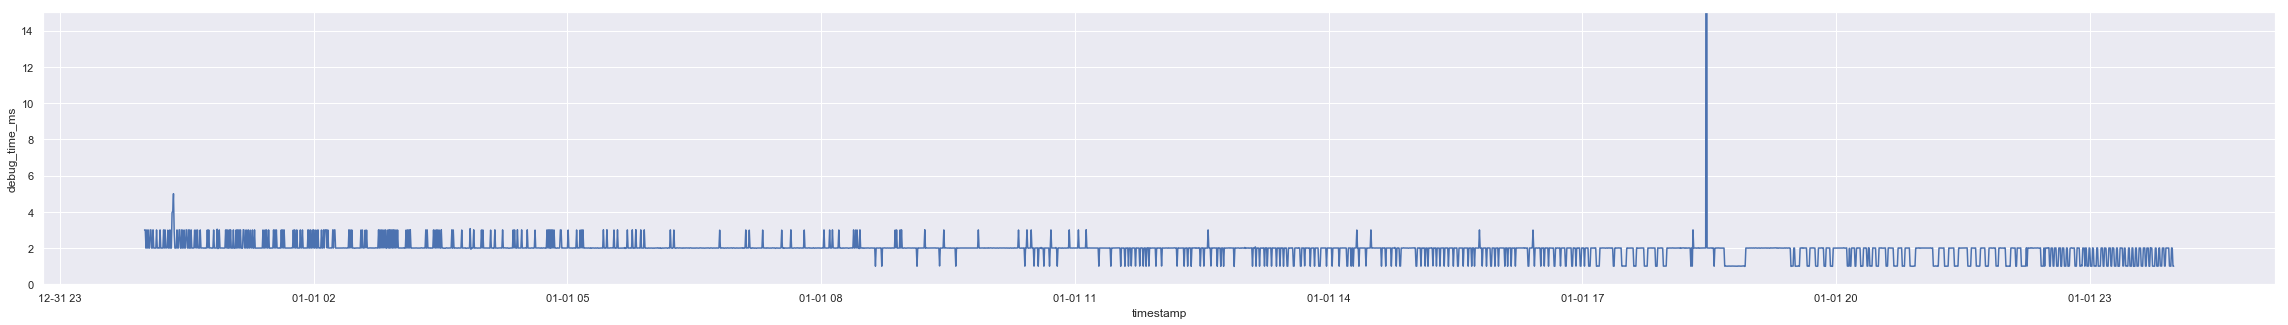

In [122]:
iter_count = 0
merged_v1_1_df = test_merge(prod_df, measure_df, merge_func=merge_v1_1)
print('iter count:', iter_count)
print('compare_time (sec):', nano2sec(compare_time), 'compare_time / iter (ms):', nano2milli(compare_time/iter_count))
merged_v1_1_df.head()

#### Test merge_v2

>> Done!
  >> Total time: 6.1182s
  >> Time per measurement: 2.1244s
  >> Mean time: 1.6014576388888833
  >> Max time: 59.982
  >> Time at 25%: 1.0
  >> Time at 50%: 1.994
  >> Time at 75%: 2.0
  >> Time at 90%: 2.004
  >> Time at 95%: 2.007
  >> Time at 95%: 2.999
>> Merged stats:
  >> Number of production events: 10.0
  >> Number of measurements per event: 180.1
iter count: 20700
compare_time (sec): 0.616839 compare_time / iter (ms): 0.029798985507246377


,timestamp,m1,m2,m3,m4,m5,finished_time,debug_time_ms
181,2018-01-01 01:30:30,68.108305,74.521933,32.397499,54.095351,34.772458,2018-01-01 03:00:04,0.999
182,2018-01-01 01:31:00,41.789023,50.819777,25.278318,34.802171,43.864491,2018-01-01 03:00:04,1.997
183,2018-01-01 01:31:30,76.797885,56.761951,66.229944,55.841921,55.903782,2018-01-01 03:00:04,0.998
184,2018-01-01 01:32:00,49.333087,50.288513,63.647841,29.194204,25.185023,2018-01-01 03:00:04,1.012
185,2018-01-01 01:32:30,31.098806,51.672563,60.140801,54.277800,31.212572,2018-01-01 03:00:04,0.979


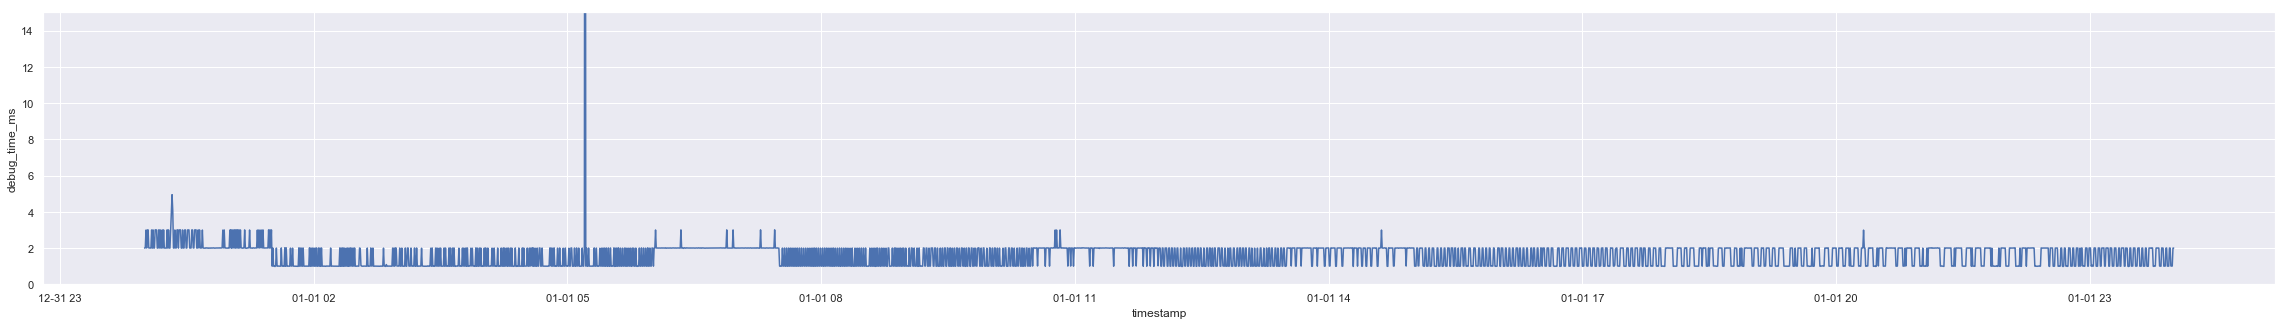

In [123]:
iter_count = 0
compare_time = 0
merged_v2_df = test_merge(prod_df, measure_df, merge_func=merge_v2)
print('iter count:', iter_count)
print('compare_time (sec):', nano2sec(compare_time), 'compare_time / iter (ms):', nano2milli(compare_time/iter_count))
merged_v2_df.head()

#### Test merge_v3

>> Done!
  >> Total time: 5.9553s
  >> Time per measurement: 2.0678s
  >> Mean time: 1.5648513888888744
  >> Max time: 61.974
  >> Time at 25%: 0.999
  >> Time at 50%: 1.984
  >> Time at 75%: 1.999
  >> Time at 90%: 2.003
  >> Time at 95%: 2.012
  >> Time at 95%: 3.001
>> Merged stats:
  >> Number of production events: 10.0
  >> Number of measurements per event: 180.1
iter count: 7578
compare_time (sec): 0.541778 compare_time / iter (ms): 0.07149353391396146


,timestamp,m1,m2,m3,m4,m5,finished_time,debug_time_ms
181,2018-01-01 01:30:30,68.108305,74.521933,32.397499,54.095351,34.772458,2018-01-01 03:00:04,0.999
182,2018-01-01 01:31:00,41.789023,50.819777,25.278318,34.802171,43.864491,2018-01-01 03:00:04,2.000
183,2018-01-01 01:31:30,76.797885,56.761951,66.229944,55.841921,55.903782,2018-01-01 03:00:04,1.995
184,2018-01-01 01:32:00,49.333087,50.288513,63.647841,29.194204,25.185023,2018-01-01 03:00:04,1.997
185,2018-01-01 01:32:30,31.098806,51.672563,60.140801,54.277800,31.212572,2018-01-01 03:00:04,1.000


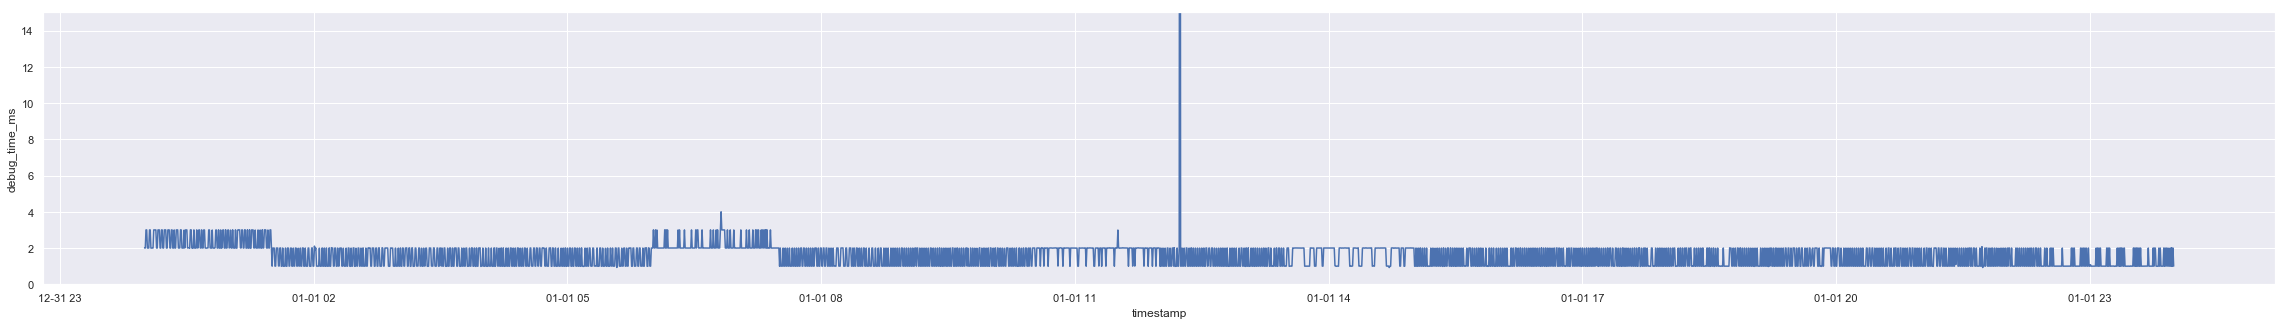

In [124]:
_index_start = 0
iter_count = 0
compare_time = 0
merged_v2_df = test_merge(prod_df, measure_df, merge_func=merge_v3)
print('iter count:', iter_count)
print('compare_time (sec):', nano2sec(compare_time), 'compare_time / iter (ms):', nano2milli(compare_time/iter_count))
merged_v2_df.head()

>> Done!
  >> Total time: 0.1771s
  >> Time per measurement: 0.0615s
  >> Mean time: 17.6065
  >> Max time: 31.259
  >> Time at 25%: 15.62425
  >> Time at 50%: 18.5355
  >> Time at 75%: 22.13925
  >> Time at 90%: 31.251800000000003
  >> Time at 95%: 31.2554
  >> Time at 95%: 31.258280000000003
>> Merged stats:
  >> Number of production events: 10.0
  >> Number of measurements per event: 1.0
iter count: 0


ZeroDivisionError: division by zero

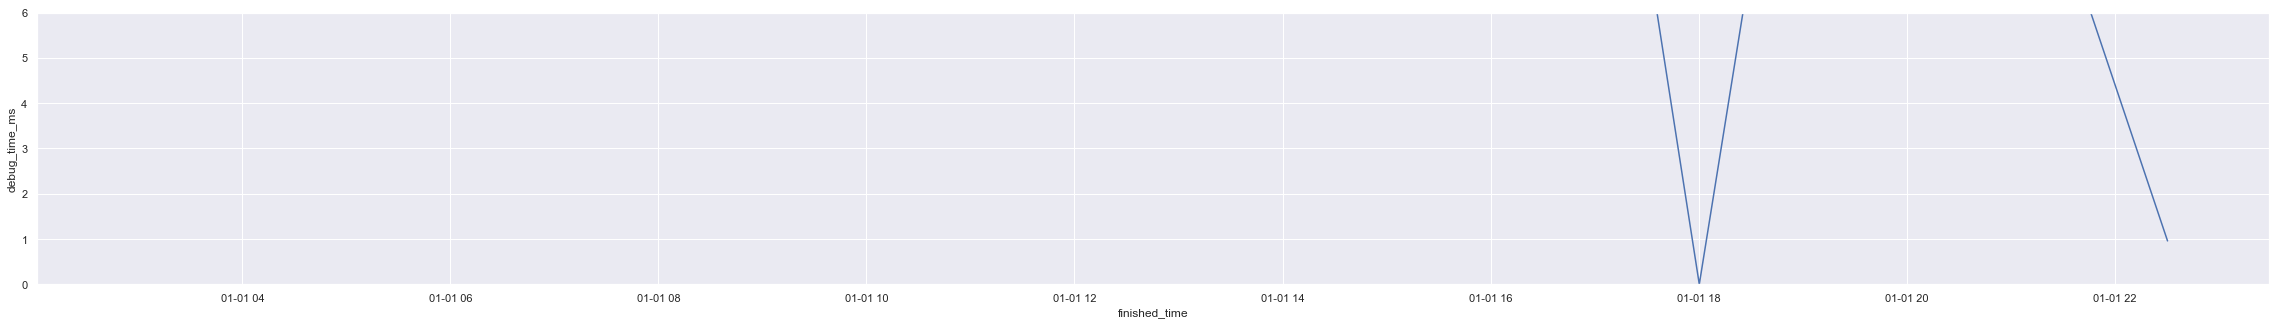

In [248]:
_index_start = 0
iter_count = 0
compare_time = 0
merged_v2_df = test_merge(prod_df, measure_df, merge_func=merge_v4)
print('iter count:', iter_count)
print('compare_time (sec):', nano2sec(compare_time), 'compare_time / iter (ms):', nano2milli(compare_time/iter_count))
merged_v2_df.head()